In [1]:
import pandas as pd
import numpy as np
from sklearn import svm, metrics
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, root_mean_squared_error 
from IPython.display import clear_output
scalar = MinMaxScaler()

In [2]:
df = pd.read_csv('IGFC_new.csv')
df.shape

(4317, 15)

In [3]:
x = df.drop(['Power', 'CO2_emitted', 'H2_produced', 'current_density', 'cell_current'], axis=1).values
y = df.iloc[:, 10:12].valuesx = scalar.fit_transform(x)

In [4]:
df.head(5)

,decomp_temp,pyrol_temp,gasifier_temp,air_to_biomass_ratio,gasifier_length,gasifier_diameter,fuel_cell_temp,Acell,fuel_utilization_factor,depleted_fuel_frac,Power,CO2_emitted,H2_produced,current_density,cell_current
0,551.0,641.0,869.0,0.98,2.24,0.50,923.43,0.29304,0.99,0.11,2141.357160,1886.39243,81.915349,10486.981500,3073.105059
1,414.0,632.0,703.0,0.87,2.24,1.32,947.21,0.37042,0.59,0.22,1378.055296,1710.22815,77.890237,3013.052220,1116.094803
2,514.0,693.0,769.0,0.84,1.49,1.43,884.47,0.29873,0.66,0.34,1166.323633,2880.51790,96.356887,4063.133978,1213.780013
3,519.0,683.0,792.0,0.96,2.28,1.20,939.74,0.36872,0.99,0.28,2447.514332,2683.42242,94.015871,7192.630499,2652.066718
4,549.0,685.0,868.0,0.86,1.18,0.56,901.48,0.37955,0.57,0.34,1419.335998,2710.64310,94.232781,3207.377315,1217.360060


In [5]:
param1 = {
    'regressor': [MultiOutputRegressor(GradientBoostingRegressor())],
    'regressor__estimator__n_estimators': [100, 200, 300],
    'regressor__estimator__learning_rate': [0.01, 0.05, 0.1],
    'regressor__estimator__max_depth': [3, 4, 5],
    'regressor__estimator__min_samples_split': [2, 5, 10],
    'regressor__estimator__min_samples_leaf': [1, 2, 4],
    'regressor__estimator__subsample': [0.8, 0.9, 1.0],
    'regressor__estimator__max_features': ['sqrt', 'log2', None]
}

In [5]:
param2 = {
    'regressor': [MultiOutputRegressor(KNeighborsRegressor())],
    'regressor__estimator__n_neighbors': [2, 5, 10, 25, 50],
    'regressor__estimator__weights': ['uniform', 'distance'],
    'regressor__estimator__metric': ['euclidean', 'manhattan', 'minkowski'],
    'regressor__estimator__algorithm': ['ball_tree', 'auto', 'brute', 'kd_tree']
}

In [6]:
param3 = {
    'regressor': [MultiOutputRegressor(SVR())],
    'regressor__estimator__kernel':['rbf', 'sigmoid', 'linear']
}

In [7]:
param4 = {
    'regressor': [RandomForestRegressor(random_state=42)],
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2'],
    'regressor__bootstrap': [True, False]
}

In [8]:
param5 = {
    'regressor': [XGBRegressor()],
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__min_child_weight': [1, 5],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0]
}

params = [param1]

In [9]:
steps = list()
steps.append(('scaler', scalar))
steps.append(('regressor', RandomForestRegressor(random_state=42)))
pipeline = Pipeline(steps=steps)

In [10]:
grid = GridSearchCV(pipeline, params, cv=2, n_jobs=-1, scoring='r2').fit(x, y)

In [11]:
print(grid.best_params_, grid.best_score_)

{'regressor': MultiOutputRegressor(estimator=GradientBoostingRegressor()), 'regressor__estimator__learning_rate': 0.05, 'regressor__estimator__max_depth': 3, 'regressor__estimator__max_features': None, 'regressor__estimator__min_samples_leaf': 1, 'regressor__estimator__min_samples_split': 5, 'regressor__estimator__n_estimators': 100, 'regressor__estimator__subsample': 0.8} 0.8511098600038195


In [12]:
means = grid.cv_results_['mean_test_score']
params = grid.cv_results_['params']

res = pd.DataFrame(list(zip(means, params)), columns=['R2_Score', 'Params'])
print(res)

      R2_Score                                             Params
0    -1.575261  {'regressor': MultiOutputRegressor(estimator=G...
1    -1.577888  {'regressor': MultiOutputRegressor(estimator=G...
2    -1.588136  {'regressor': MultiOutputRegressor(estimator=G...
3    -1.496871  {'regressor': MultiOutputRegressor(estimator=G...
4    -1.487473  {'regressor': MultiOutputRegressor(estimator=G...
...        ...                                                ...
2929 -1.581747  {'regressor': XGBRegressor(base_score=None, bo...
2930 -1.558188  {'regressor': XGBRegressor(base_score=None, bo...
2931 -1.581553  {'regressor': XGBRegressor(base_score=None, bo...
2932 -1.559739  {'regressor': XGBRegressor(base_score=None, bo...
2933 -1.581500  {'regressor': XGBRegressor(base_score=None, bo...

[2934 rows x 2 columns]


In [13]:
from sklearn.metrics import mean_squared_error, accuracy_score
regressor = grid.best_params_['regressor']
regressor.fit

In [15]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs = SFS(
    forest,
    k_features=10,
    forward=True,
    floating=False,
    scoring='r2',
    cv=0,
    n_jobs=1
)
feature_names = list(df.columns)
sfs.fit(x, y, feature_names)

SequentialFeatureSelector(cv=0,
                          estimator=MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.05,
                                                                                             max_features='log2',
                                                                                             min_samples_split=5,
                                                                                             subsample=0.9)),
                          k_features=(10, 10), scoring='r2')

In [16]:
pd.DataFrame(sfs.get_metric_dict()).T

C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)",[0.26810821736497886],0.268108,"(1,)",NaN,0.0,NaN
2,"(1, 8)",[0.45428292128172965],0.454283,"(1, 8)",NaN,0.0,NaN
3,"(1, 6, 8)",[0.6236244054151426],0.623624,"(1, 6, 8)",NaN,0.0,NaN
4,"(1, 6, 7, 8)",[0.6459012163512433],0.645901,"(1, 6, 7, 8)",NaN,0.0,NaN
5,"(0, 1, 6, 7, 8)",[0.6449790651075169],0.644979,"(0, 1, 6, 7, 8)",NaN,0.0,NaN
6,"(0, 1, 2, 6, 7, 8)",[0.6427866014394765],0.642787,"(0, 1, 2, 6, 7, 8)",NaN,0.0,NaN
7,"(0, 1, 2, 5, 6, 7, 8)",[0.6388990239087111],0.638899,"(0, 1, 2, 5, 6, 7, 8)",NaN,0.0,NaN
8,"(0, 1, 2, 4, 5, 6, 7, 8)",[0.6461553575376651],0.646155,"(0, 1, 2, 4, 5, 6, 7, 8)",NaN,0.0,NaN
9,"(0, 1, 2, 4, 5, 6, 7, 8, 9)",[0.6450054361683748],0.645005,"(0, 1, 2, 4, 5, 6, 7, 8, 9)",NaN,0.0,NaN
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",[0.6412358156014156],0.641236,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",NaN,0.0,NaN


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=20)
forest = MultiOutputRegressor(GradientBoostingRegressor(learning_rate= 0.05, \
                                                        max_depth= 3, \
                                                        max_features= None, \
                                                        min_samples_leaf= 1, \
                                                        min_samples_split= 5, \
                                                        n_estimators= 100, \
                                                        subsample= 0.8))
forest.fit(x, y)

MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.05,
                                                         min_samples_split=5,
                                                         subsample=0.8))

In [17]:
y_ = []
for i in range(0,len(y_pred)):
    y_.append(y_pred[i][0])
    
y_t = []

for i in range(0,len(y_test)):
    y_t.append(y_test[i][0])

In [18]:
y_1 = []
for i in range(0, len(y_pred)):
    y_1.append(y_pred[i][1])
    
y_1t = []

for i in range(0,len(y_test)):
    y_1t.append(y_test[i][1])

In [19]:
r2_power = r2_score(y_t, y_)
print(r2_power)

0.7010124839860201


In [20]:
r2_CO2 = r2_score(y_1t, y_1)
print(r2_CO2)

0.999891028983375


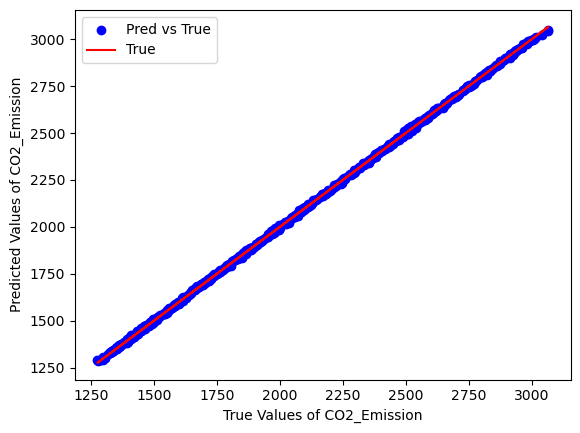

In [21]:
import matplotlib.pyplot as plt

plt.scatter(y_1t, y_1, label='Pred vs True', color='blue')
plt.plot(y_1t, y_1t, label='True', color='red')
plt.xlabel('True Values of CO2_Emission')
plt.ylabel('Predicted Values of CO2_Emission')
plt.legend()
plt.savefig('new_GB_Result_CO2.png')

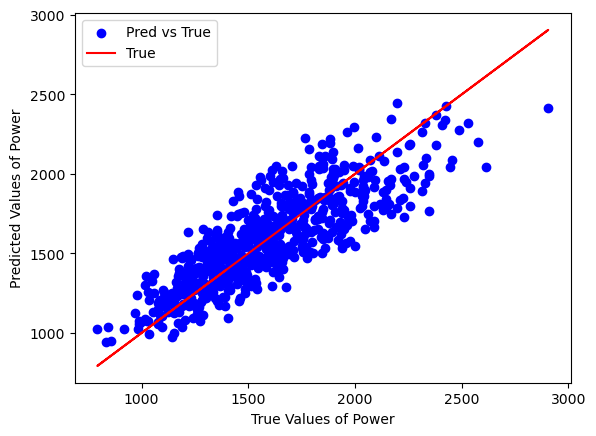

In [22]:
import matplotlib.pyplot as plt

plt.scatter(y_t, y_, label='Pred vs True', color='blue')
plt.plot(y_t, y_t, label='True', color='red')
plt.xlabel('True Values of Power')
plt.ylabel('Predicted Values of Power')
plt.legend()
plt.savefig('new_GB_Result_Power.png')

In [6]:
df = pd.read_csv('IGFC_new.csv')

x = df.drop(['Power', 'CO2_emitted', 'H2_produced', 'current_density', 'cell_current'], axis=1).values
y = df.iloc[:, 10:12].values


forest = grid.best_params_['regressor']
forest.fit(x, y)

NameError: name 'grid' is not defined

In [8]:
from deap import base, creator, tools, algorithms

import random
creator.create('FitnessMulti', base.Fitness, weights=(-1.0, 1.0))
creator.create('Individual', list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

def round_random(lower, upper, dp):
    return round(random.uniform(lower, upper), dp)

toolbox.register('attr_decomp_temp', round_random, 400, 600, 0)
toolbox.register('attr_pyrol_temp', round_random, 600, 700, 0)
toolbox.register('attr_gasifier_temp', round_random, 700, 900, 1)
toolbox.register('attr_air_to_biomass_ratio', round_random, 0.6, 1, 2)
toolbox.register('attr_gasifier_length', round_random, 1, 3, 2)
toolbox.register('attr_gasifier_diameter', round_random, 0.5, 2, 2)
toolbox.register('attr_fuel_cell_temp', round_random, 850, 1000, 0)
toolbox.register('attr_Acell', round_random, 0.25, 0.4, 5)
toolbox.register('attr_fuel_utilization_factor', round_random, 0.5, 1, 2)
toolbox.register('attr_depleted_fuel_frac', round_random, 0.1, 0.4, 2)
    

In [9]:
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_decomp_temp, toolbox.attr_pyrol_temp, toolbox.attr_gasifier_temp,\
                 toolbox.attr_air_to_biomass_ratio, toolbox.attr_gasifier_length, toolbox.attr_gasifier_diameter,\
                 toolbox.attr_fuel_cell_temp, toolbox.attr_Acell, toolbox.attr_fuel_utilization_factor,\
                 toolbox.attr_depleted_fuel_frac), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [10]:
# def minimize_co2(individual):
#     output = forest.predict([individual])
#     return output[0]

# def maximize_power(individual):
#     output = forest.predict([individual])
#     return output[0][0]

def objective(individual):
    output = forest.predict([individual])
    return output[0][0], output[0][1]

def constraint(individual):
    penalty = 0
    if individual[0] <= 400 or individual[0] >= 600:
        penalty += 1000
    if individual[1] <= 600 or individual[1] >= 700:
        penalty += 1000
    if individual[2] <= 700 or individual[2] >= 900:
        penalty += 1000
    if individual[3] <= 0.1 or individual[3] >= 1:
        penalty += 1000
    if individual[4] <= 1 or individual[4] >= 3:
        penalty += 1000
    if individual[5] <= 0.5 or individual[5] >= 2:
        penalty += 1000
    if individual[6] <= 850 or individual[6] >= 1000:
        penalty += 1000
    if individual[7] <= 0.25 or individual[7] >= 0.4:
        penalty += 1000
    if individual[8] <= 0.5 or individual[8] >= 1:
        penalty += 1000
    if individual[9] <= 0.1 or individual[9] >= 0.4:
        penalty += 1000
    return penalty

In [11]:
def evaluate(individual):
    power, co2 = objective(individual)
    penalty = constraint(individual)
    return co2+penalty, power-penalty

In [12]:
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=20, indpb=0.2)  
toolbox.register("select", tools.selNSGA2)

In [20]:
def main():
    random.seed(42)
    pop = toolbox.population(n=600)
    cxpb = 0.3
    mutpb = 0.1
    ngen = 1000
    
    hof = tools.ParetoFront()
    
    statistics = tools.Statistics(lambda ind: ind.fitness.values)
    
    statistics.register("avg", np.mean, axis=0)
    statistics.register("std", np.std, axis=0)
    statistics.register("min", np.min, axis=0)
    statistics.register("max", np.max, axis=0)
    
                        
    algorithms.eaSimple(pop, toolbox, cxpb, mutpb, ngen, 
                        statistics, halloffame=hof, verbose=False)   
    
    return hof

In [21]:
hof = main()
print(hof)

[[557.0, 600.1926106637161, 724.3, 0.77, 1.97, 0.57, 856.0, 0.26536, 0.98, 0.15], [490.0, 601.0, 715.8, 0.88, 1.55, 0.65, 974.0, 0.33251, 0.98, 0.14], [590.0, 601.7139955100994, 709.9, 0.74, 1.94, 0.79, 976.0, 0.37259, 0.97, 0.14], [591.0, 601.0, 739.7858701814084, 0.74, 1.54, 1.29, 997.0, 0.39803, 0.97, 0.14], [527.0, 603.3531461895863, 727.1, 0.95, 2.34, 1.44, 987.2259452038072, 0.3791, 0.98, 0.17], [567.7258498133443, 603.0665041501246, 746.690414892082, 0.95, 2.34, 1.44, 987.2259452038072, 0.3791, 0.98, 0.36], [502.37563549508815, 605.0, 892.2868017954678, 0.65, 1.91, 1.78, 980.0, 0.36376, 0.99, 0.22], [591.0, 691.0, 840.9, 0.88, 1.58, 0.9, 979.0, 0.39782, 0.98, 0.25], [566.0, 691.0, 840.9, 0.88, 1.58, 0.9, 979.0, 0.39782, 0.98, 0.19]]


In [22]:
for individual in hof:
        print(individual)

[557.0, 600.1926106637161, 724.3, 0.77, 1.97, 0.57, 856.0, 0.26536, 0.98, 0.15]
[490.0, 601.0, 715.8, 0.88, 1.55, 0.65, 974.0, 0.33251, 0.98, 0.14]
[590.0, 601.7139955100994, 709.9, 0.74, 1.94, 0.79, 976.0, 0.37259, 0.97, 0.14]
[591.0, 601.0, 739.7858701814084, 0.74, 1.54, 1.29, 997.0, 0.39803, 0.97, 0.14]
[527.0, 603.3531461895863, 727.1, 0.95, 2.34, 1.44, 987.2259452038072, 0.3791, 0.98, 0.17]
[567.7258498133443, 603.0665041501246, 746.690414892082, 0.95, 2.34, 1.44, 987.2259452038072, 0.3791, 0.98, 0.36]
[502.37563549508815, 605.0, 892.2868017954678, 0.65, 1.91, 1.78, 980.0, 0.36376, 0.99, 0.22]
[591.0, 691.0, 840.9, 0.88, 1.58, 0.9, 979.0, 0.39782, 0.98, 0.25]
[566.0, 691.0, 840.9, 0.88, 1.58, 0.9, 979.0, 0.39782, 0.98, 0.19]


In [23]:
result = []

for param in hof:
    result.append(forest.predict([param]))

In [24]:
result

[array([[1289.30339266, 1310.13731125]]),
 array([[2218.39654671, 1310.18196014]]),
 array([[2305.94282005, 1310.94991879]]),
 array([[2337.06272968, 1330.18215426]]),
 array([[2353.83395127, 1338.10742045]]),
 array([[2358.34157694, 1344.84138963]]),
 array([[2366.65961927, 1421.89208274]]),
 array([[2366.89042907, 2835.44906545]]),
 array([[2366.89042907, 2835.44906545]])]

In [25]:
power = []
co2 = []
for res in result:
    power.append(res[0][0])
    co2.append(res[0][1])

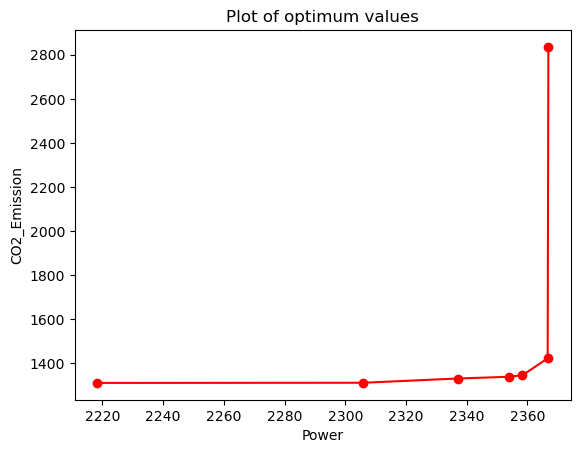

In [27]:
import matplotlib.pyplot as plt
plt.plot(power[1:8], co2[1:8], color='red', marker = 'o')
plt.xlabel('Power')
plt.ylabel('CO2_Emission')
plt.title('Plot of optimum values')
plt.savefig('optimum.png')

In [16]:
no_of_iterations = 50
power = []
co2 = []
import random
for i in range(no_of_iterations):

    decomp_temp = 459
    pyrol_temp = 625
    gasifier_temp = 714.8
    air_to_biomass_ratio = 0.74
    gasifier_length = 1.05
    gasifier_diameter = 0.51
    fuel_cell_temp_in_K = 900
    fuel_cell_temp = fuel_cell_temp_in_K - 273
    Acell = 0.39916
    fuel_utilization_factor = round(random.uniform(0.5, 1), 2)
    depleted_fuel_frac = 0.3
    
    res = forest.predict([[decomp_temp, pyrol_temp, gasifier_temp, \
                                                                                 air_to_biomass_ratio, gasifier_length, \
                                                                                 gasifier_diameter, fuel_cell_temp, \
                                                                                 Acell, fuel_utilization_factor, \
                                                                                 depleted_fuel_frac]])


    power.append(res[0][1])
    co2.append(res[0][0])

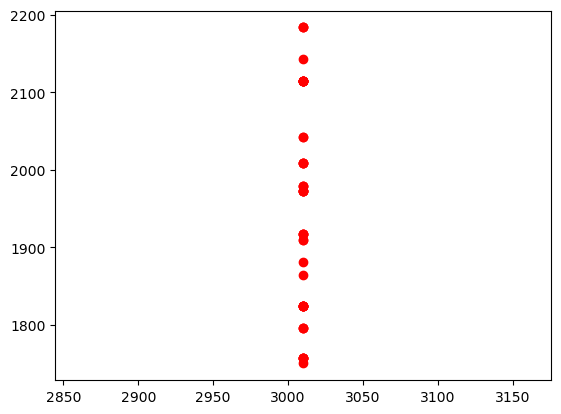

In [17]:
import matplotlib.pyplot as plt
plt.scatter(power, co2, color='red', marker = 'o')

In [20]:
forest.predict(459.0, 625.0, 714.8, 0.74, 1.05, 0.51, 900.0, 0.39916, 0.99, 0.3)

TypeError: _MultiOutputEstimator.predict() takes 2 positional arguments but 11 were given